# Bankruptcy prediction analysis with dataset of polish companies

#### Author : AeLee Im (aelee.im@gmail.com)
    
#### Contents
1. Importing Libraries 
    - Install the required libraries
    - Import required libraries    
2. Importing and preparing the data
    - Set working directory : to define the current file directory for importing & exporting data
    - Load .arff dataset and convert it to dataframe
    - Set the appropriate data type of every feature and label  
3. Data pre-processing
    - 3-A. Missing value analysis 
        - 3-A-1. Check out the volume of missing value
            - How many missing values are detected by each dataset(i year)?
            - Which attributes shows the most highest missing value by each dataset?
        - 3-A-2. Check out the distribution of missing values
            - Missing values are distributed over the dataset or congregated in the certain features?
    - 3-B. Data Imputation for missing values
        - 3-B-1. KNN Imputation
        - 3-B-2. Random Forest(missForest) Imputation
    - 3-C. correlation analysis
    - 3-D. Feature Selection via Boruta
    - 3-E. Dealing with imbalanced data
        - 3-E-1. Check out whether dataset is imbalanced
        - 3-E-2. Oversampling with SMOTE (Synthetic Minority Over Sampling Technique)       
4. Model Building
    - 4-A. K-Fold Cross Validation
    - 4-B. Preparation of classification models
        - 4-B-1. Gaussian Naive Bayes classifier
        - 4-B-2. Logistic Regression classifier
        - 4-B-3. Decision Tree Classifier
        - 4-B-4. Random Forest Classifier
        - 4-B-5. Balanced Bagging Classifier
    - 4-C. Building a prediction model    
5. Model Analysis
    - 5-A. Model Ranking 
        - Q. Which model shows better performance?        
6. Calculate the probability of backuptcy using selected model 
    - Q. What is the probability of bankruptcy after 1, 2, 3 years?
        - 6-A. Import the selected Model
        - 6-B. Calculate the chance of bankruptcy by using the selected model

# 1. Importing Libraries

### Install the required libraries

In [2]:
! pip install missingno

In [6]:
! pip install imbalanced-learn

In [18]:
! pip install missingpy

     |████████████████████████████████| 49 kB 1.0 MB/s eta 0:00:01


In [100]:
! pip install Boruta

### Importing required library

In [460]:
# To get the working directory

# to get the working directory
import os
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Basic Libraries for Data organization, Statistical operations and Plotting

import numpy as np
import pandas as pd

# For loading .arff files
from scipy.io import arff
# To analyze the type of missing data
import missingno as msno
# missing value imputation : KNN, MissForest
from missingpy import KNNImputer
from missingpy import MissForest
# for splitting the dataset into train/testset
from sklearn.model_selection import train_test_split
#To perform kFold Cross Validation
from sklearn.model_selection import KFold
# Formatted counter of class labels
from collections import Counter
# Ordered Dictionary
from collections import OrderedDict
# Library imbalanced-learn to deal with the data imbalance. To use SMOTE oversampling
from imblearn.over_sampling import SMOTE 
# import the required packages for Buruta feature selection
from boruta import BorutaPy

# Impoting classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# For evaluation
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Importing and Prepring the data

### Set working directory : to define the current file path for importing & exporting data

In [12]:
# get working directory
os.getcwd()

'/Users/aeleeim/Desktop/Career/accenture/assignment'

### Load .arff dataset and convert it to dataframe

In [13]:
# Loads the 5 raw .arff files into a list
def load_arff_raw_data():
    N=5
    return [arff.loadarff('data/' + str(i+1) + 'year.arff') for i in range(N)]

# Loads the 5 raw .arff files into pandas dataframes
def load_dataframes():
    return [pd.DataFrame(data_i_year[0]) for data_i_year in load_arff_raw_data()]

# dataframes is the list of pandas dataframes for the 5 year datafiles.  
dataframes = load_dataframes()

# print the first 5 rows of a dataset 'year1'
dataframes[0].head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


### Set the appropriate data type of every feature and label

In [14]:
# convert all the numberic features for all the dataframes into float to maintain consistency
def convert_columns_type_float(dfs):
    for i in range(5):
        index = 1
        while(index<=63):
            colname = dfs[i].columns[index]
            col = getattr(dfs[i], colname)
            dfs[i][colname] = col.astype(float)
            index+=1
            
convert_columns_type_float(dataframes)

In [15]:
# Convert class label to int types
def convert_class_label_type_int(dfs):
    for i in range(len(dfs)):
        col = getattr(dfs[i], 'class')
        dfs[i]['class'] = col.astype(int)
        
convert_class_label_type_int(dataframes)

# 3. Data pre-processing

## 3-A. Missing Value Analysis

### 3-A-1. Check out the volume of missing value
#### - How many missing values are detected per each dataset(i year)?

In [515]:
# Get Clean dataframes by dropping all the rows which have missing values
def drop_nan_rows(dataframes, verbose=False):
    clean_dataframes = [df.dropna(axis=0, how='any') for df in dataframes]
    if verbose:
        for i in range(len(dataframes)):
            print(str(i+1)+'year:','Original Length=', len(dataframes[i]), 
                  '\tCleaned Length=', len(clean_dataframes[i]), 
                  '\tMissing Data=', len(dataframes[i])-len(clean_dataframes[i]), 
                  '\tPercentage(%)=', '{:0.2f}'.format((len(dataframes[i])-len(clean_dataframes[i]))/len(dataframes[i])*100))
    return clean_dataframes

# Doing a quick analysis of how many missing values are there in each of the 5 dataframes
nan_dropped_dataframes = drop_nan_rows(dataframes, verbose=True)

1year: Original Length= 7027 	Cleaned Length= 3194 	Missing Data= 3833 	Percentage(%)= 54.55
2year: Original Length= 10173 	Cleaned Length= 4088 	Missing Data= 6085 	Percentage(%)= 59.82
3year: Original Length= 10503 	Cleaned Length= 4885 	Missing Data= 5618 	Percentage(%)= 53.49
4year: Original Length= 9792 	Cleaned Length= 4769 	Missing Data= 5023 	Percentage(%)= 51.30
5year: Original Length= 5910 	Cleaned Length= 3031 	Missing Data= 2879 	Percentage(%)= 48.71


#### - Which attributes shows the most highest missing value per each dataset?

In [65]:
# List up of top 5 Attributes which has the most missing values
n=5
for i in range(n):
    print(str(i+1)+'year:\n', dataframes[i].isnull().sum().sort_values(ascending=False).head(5), '\n')

1year:
 Attr37    2740
Attr21    1622
Attr27     311
Attr60     135
Attr45     134
dtype: int64 

2year:
 Attr37    4518
Attr21    3164
Attr27     706
Attr60     543
Attr45     541
dtype: int64 

3year:
 Attr37    4736
Attr21     807
Attr27     715
Attr60     592
Attr45     591
dtype: int64 

4year:
 Attr37    4442
Attr27     641
Attr60     614
Attr45     613
Attr28     231
dtype: int64 

5year:
 Attr37    2548
Attr27     391
Attr60     268
Attr45     268
Attr24     135
dtype: int64 



### 3-A-2. Check out the distribution of missing values

#### Missing values are distributed over the dataset or concentrated on the certain features?

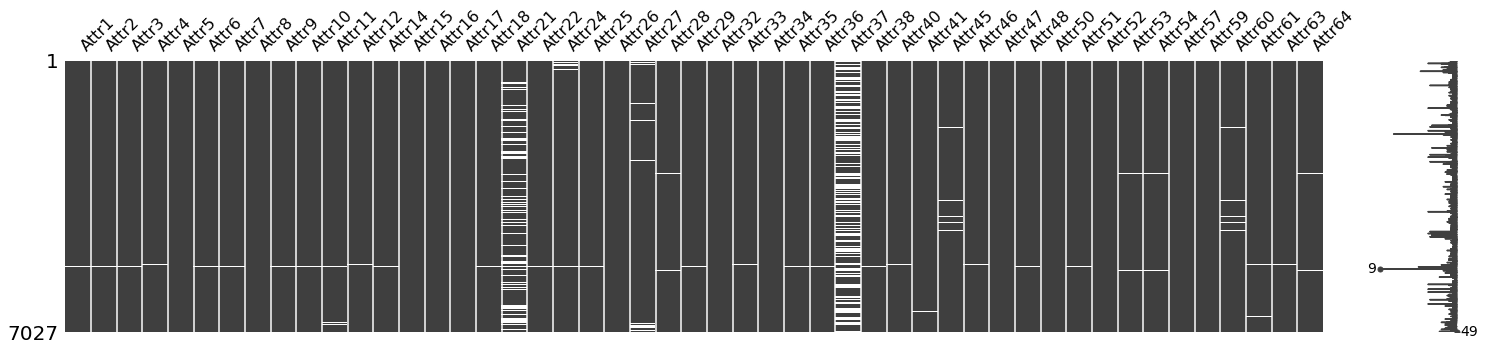

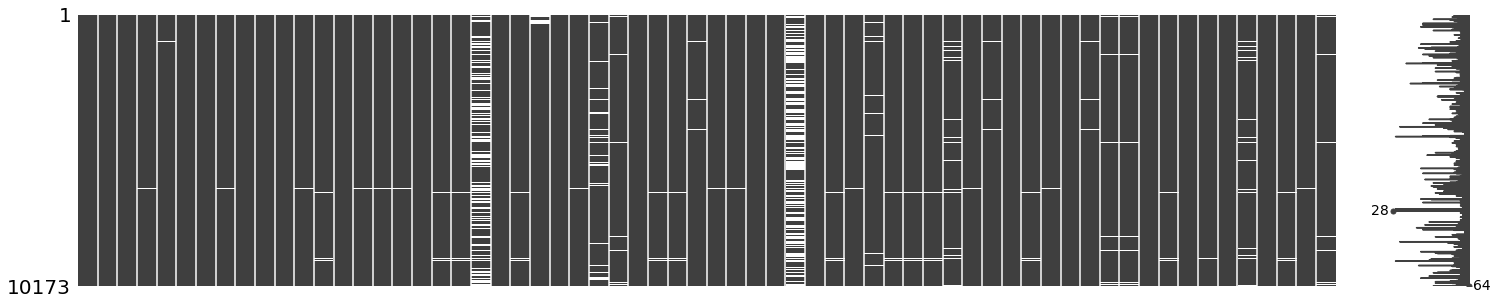

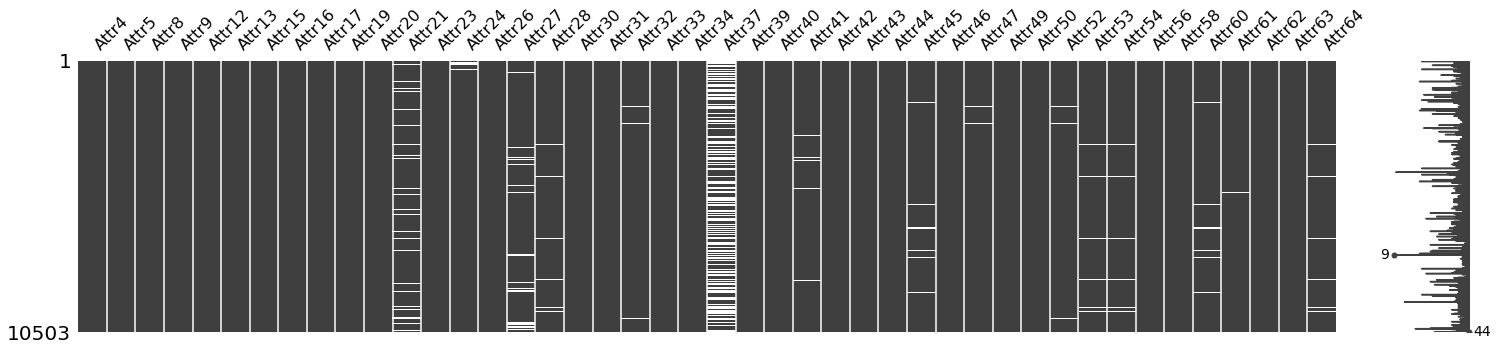

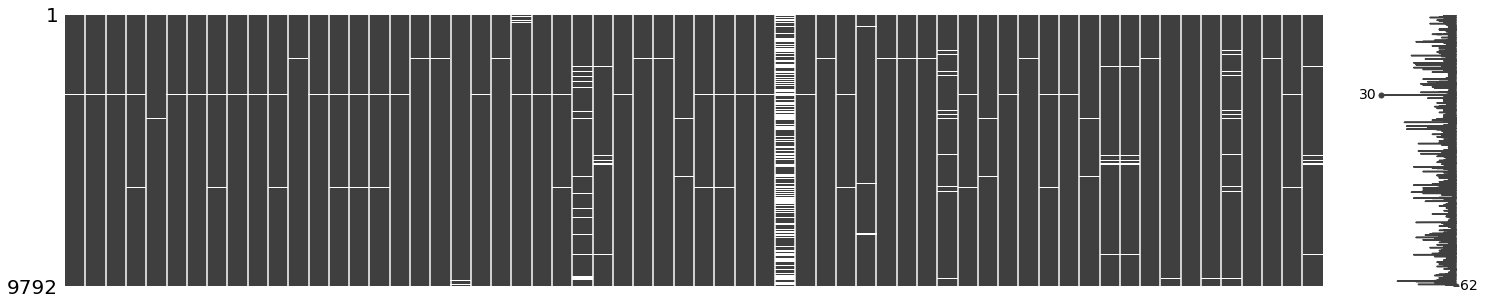

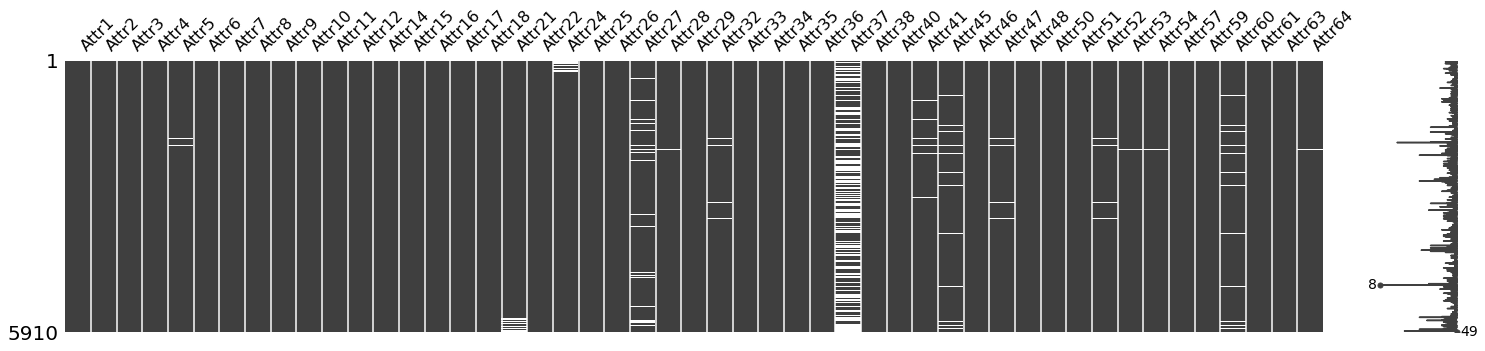

In [66]:
# generate the sparsity matrix (figure) for all the dataframes
def generate_sparsity_matrix(dfs):
    for i in range(5):
        missing_df_i = dfs[i].columns[dfs[i].isnull().any()].tolist()
        msno.matrix(dfs[i][missing_df_i], figsize=(25,5))

generate_sparsity_matrix(dataframes)

#### Each dataset shows a lot of missing values from 49.71% to 59. 82%. However, according to the results from the distribution plot of missing value, these missing value was concentrated on several attributes such as Attr37, Attr 21. 
#### There are several ways to deal with missing value. First, we could simply remove certain columns(e.g. Attr37, Attr21) since they have almost missing values within the dataset. However, in that case we should lose quite a lot of data.
#### Therefore, it seems to be risky to remove certain features according the the percentage of missing value in this case and I would like to impute the missing values instead of removing data.

## 3-B. Data Imputation for missing values

### 3-B-1. KNN Imputation

In [22]:
# Missing value imputation : KNN imputer
def perform_knn_imputation(dfs):
    imputer = KNNImputer()
    knn_imputed_datasets = [imputer.fit_transform(dfs[i]) for i in range(len(dfs))]
    return [pd.DataFrame(data=knn_imputed_datasets[i]) for i in range(len(dfs))]
    
knn_imputed_dataframes = perform_knn_imputation(dataframes)

### 3-B-2. MissForest Imputation

In [23]:
# Missing value imputation : MissForest imputer
def perform_missForest_imputation(dfs):
    imputer = MissForest()
    missForest_imputed_datasets = [imputer.fit_transform(dfs[i]) for i in range(len(dfs))]
    return [pd.DataFrame(data=missForest_imputed_datasets[i]) for i in range(len(dfs))]
    
missForest_imputed_dataframes = perform_missForest_imputation(dataframes)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


### create a dictionary of all the imputed dataframes to re-use them in the future

In [67]:
imputed_dataframes_dictionary = OrderedDict()
imputed_dataframes_dictionary['k-NN'] = knn_imputed_dataframes
imputed_dataframes_dictionary['missForest'] = missForest_imputed_dataframes

### *** Exporting and Importing imputed dataset for later use

In [26]:
# Export to pickle file for later usage
# k-NN imputed dataset
import pickle
# K-NN imputed dataset
with open('knn_imputed_dataframes', 'wb') as fp:
    pickle.dump(knn_imputed_dataframes, fp)

In [27]:
# Export to pickle file for later usage
# random forest imputed(missForest) dataset
with open('missForest_imputed_dataframes', 'wb') as fp:
    pickle.dump(missForest_imputed_dataframess, fp)

#### (Optional) Only for the moment of re-using the file
#### Below two cells should be used only for re-opened the exported dataset. If you are running the script and you already have imputed dataset, you don't have to run below two cells. Please skip these two cells, in that case.

In [49]:
# open pickle file : K-NN Imputed dataset
with (open("knn_imputed_dataframes", "rb")) as openfile:
    while True:
        try:
            knn_imputed_dataframes = pickle.load(openfile)
        except EOFError:
            break

In [54]:
# open pickle file : Random Forest(missForest) Imputed dataset
with (open("missForest_imputed_dataframes", "rb")) as openfile:
    while True:
        try:
            missForest_imputed_dataframes = pickle.load(openfile)
        except EOFError:
            break

## 3-C. correlation analysis

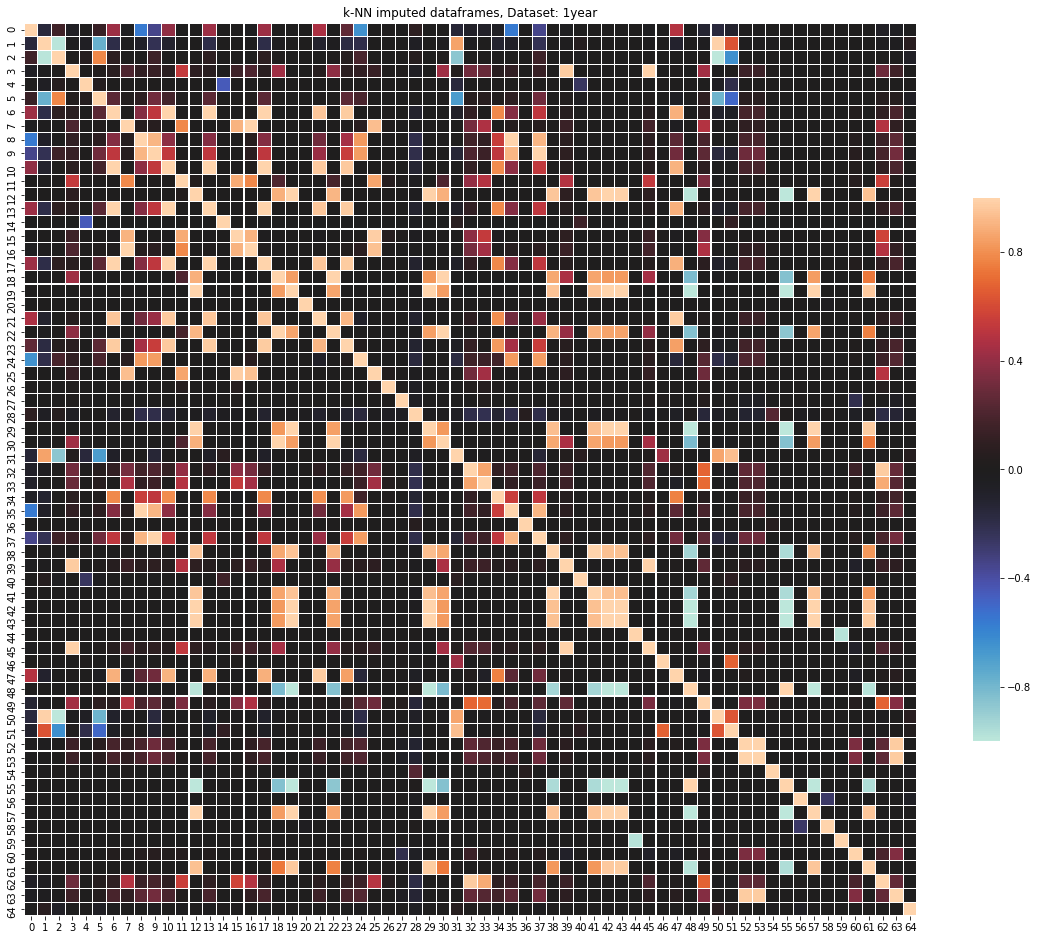

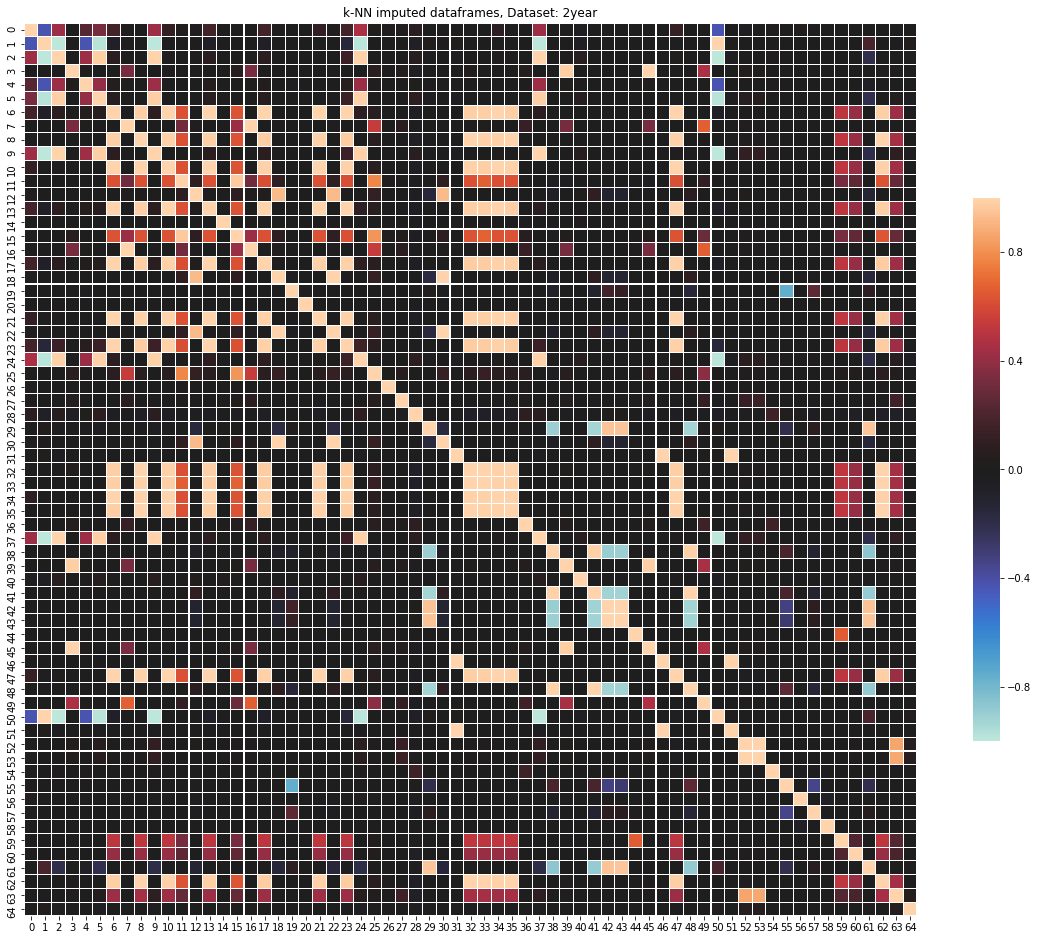

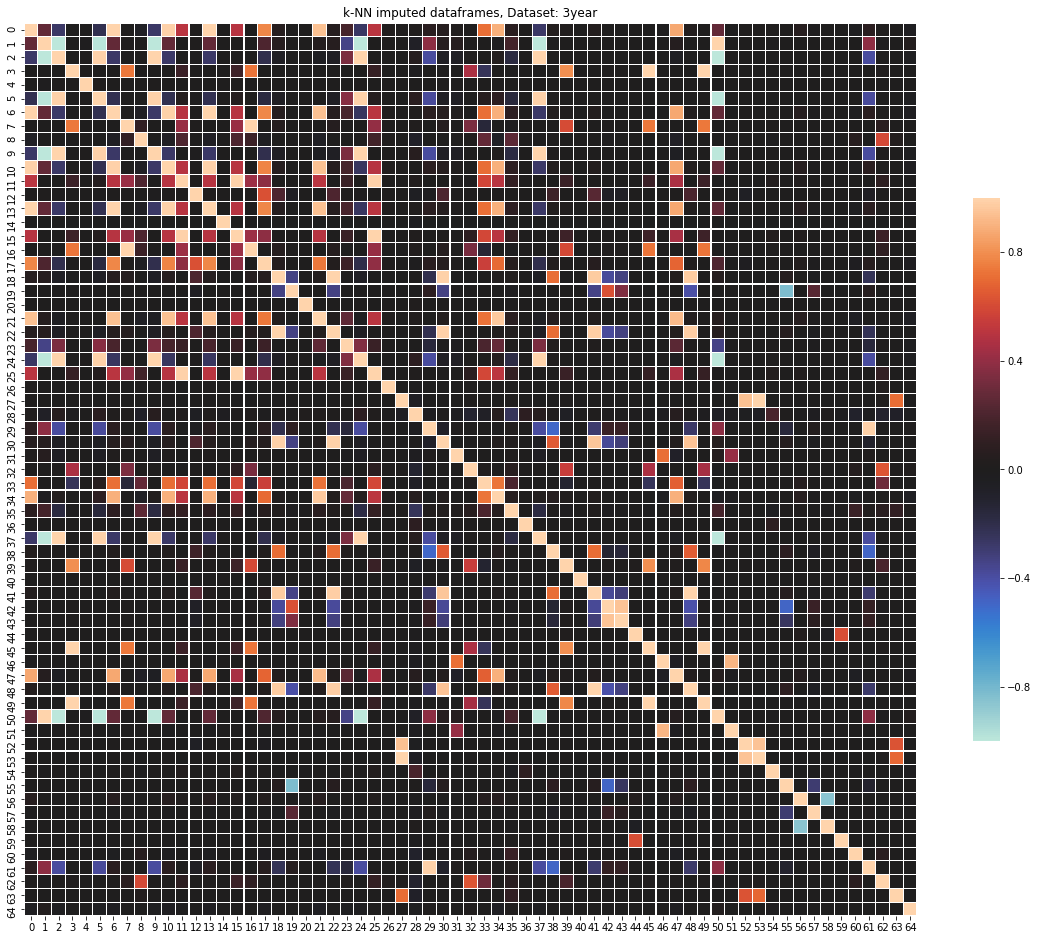

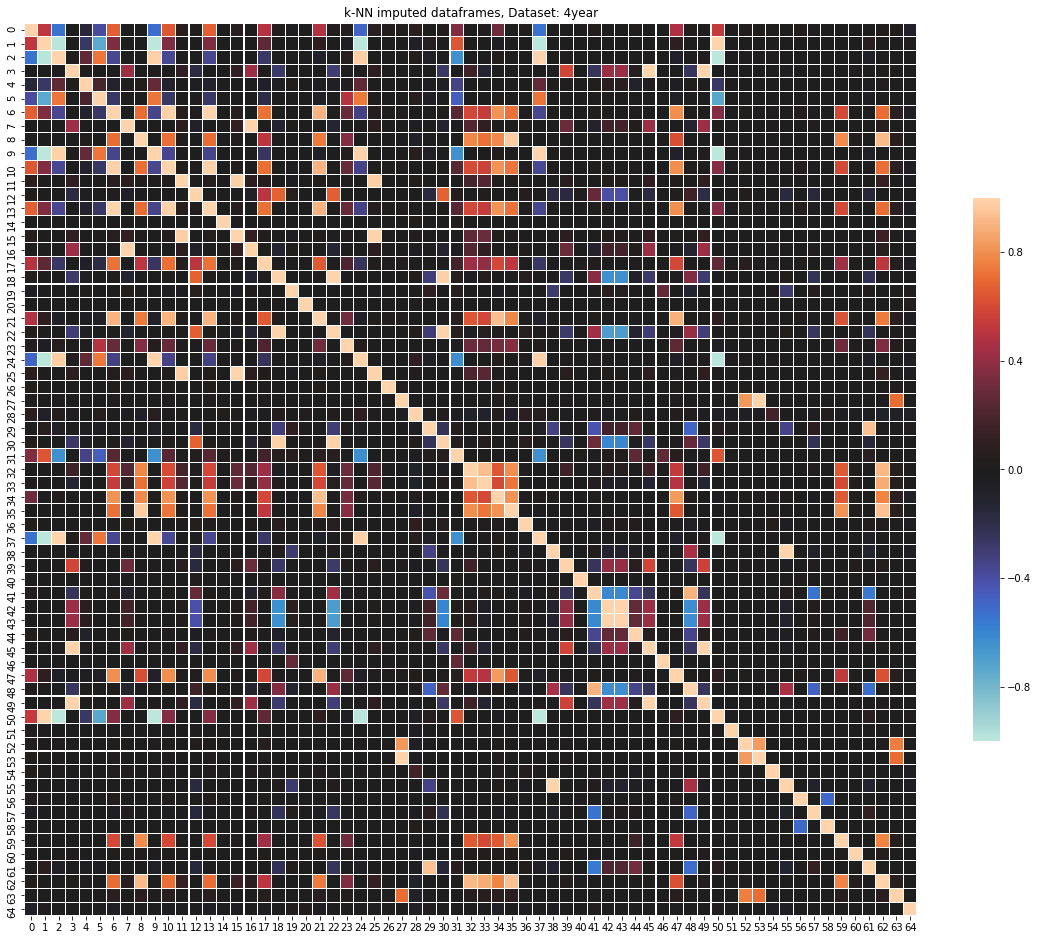

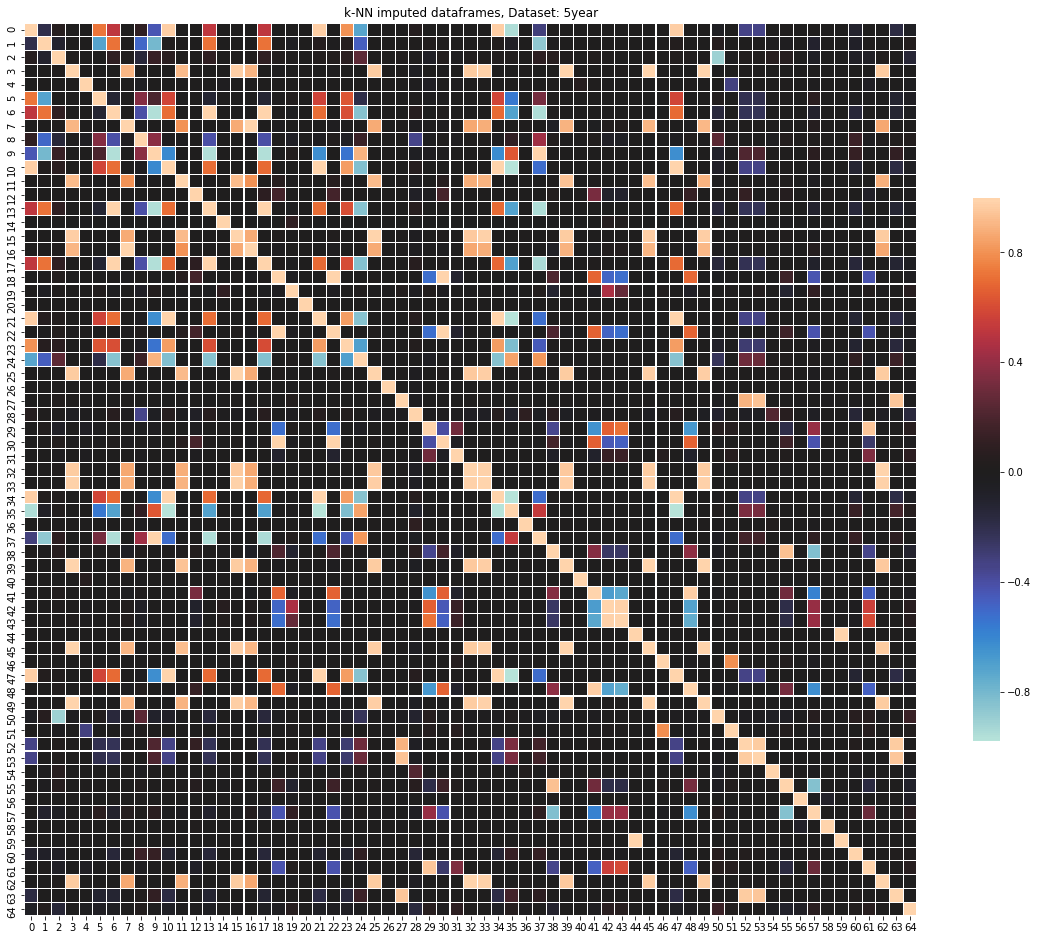

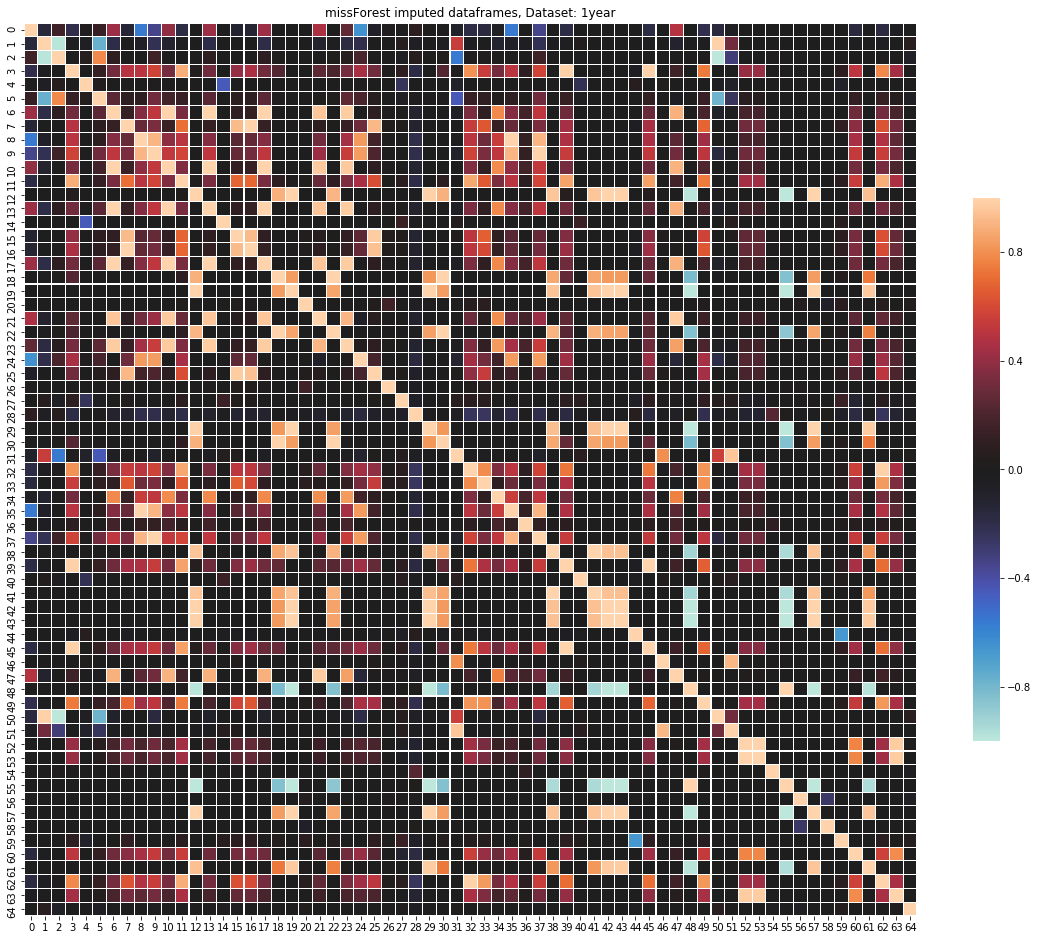

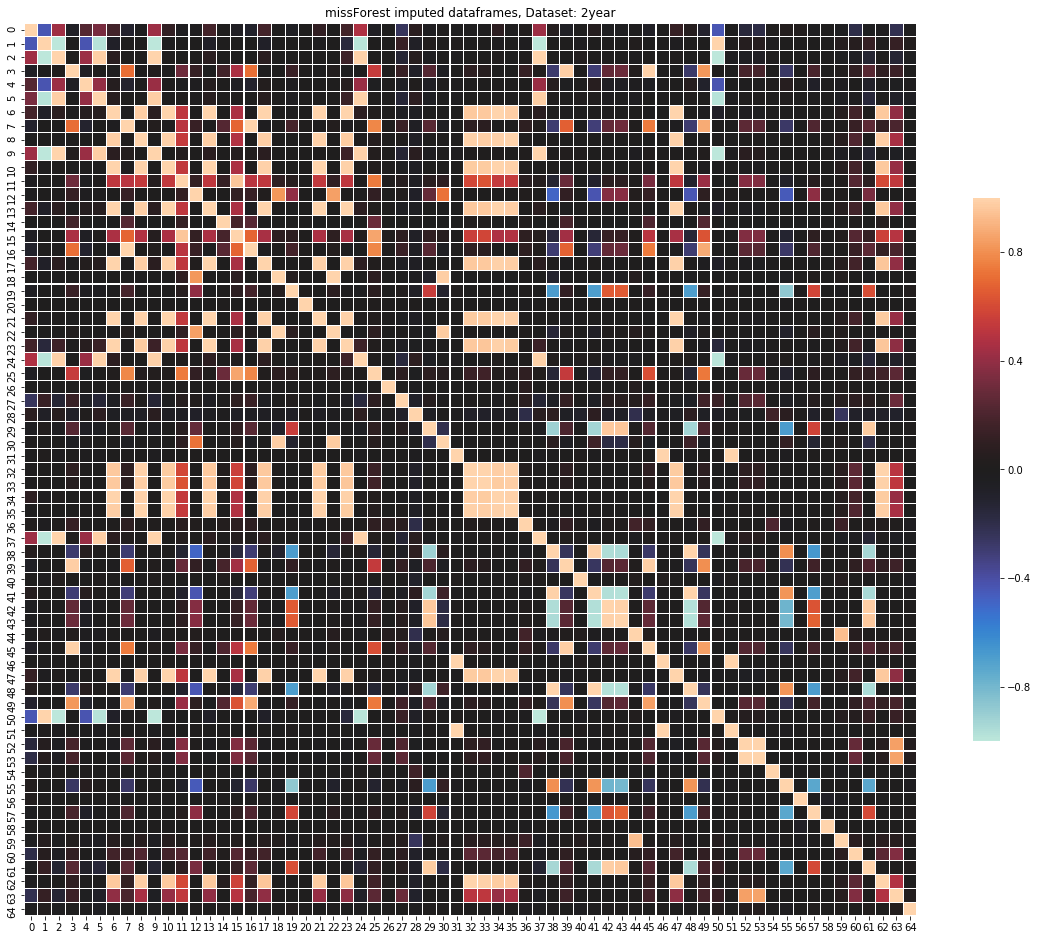

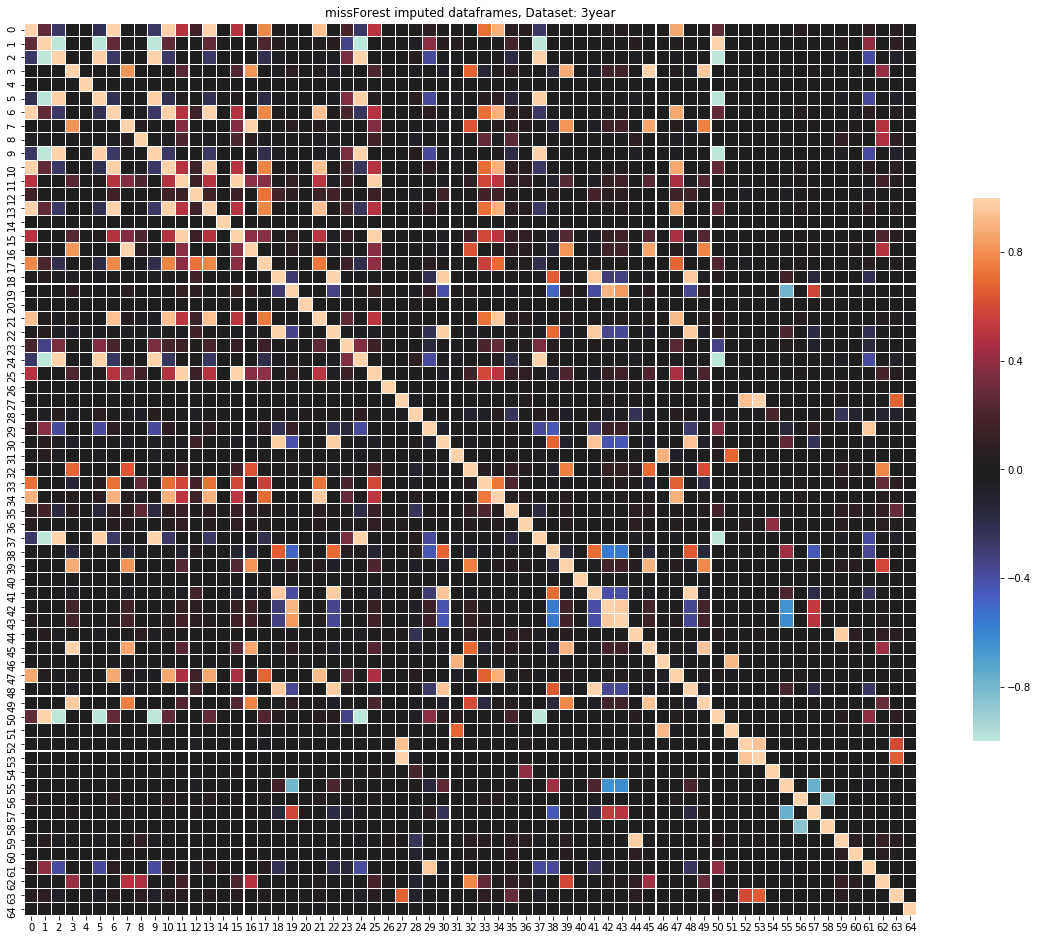

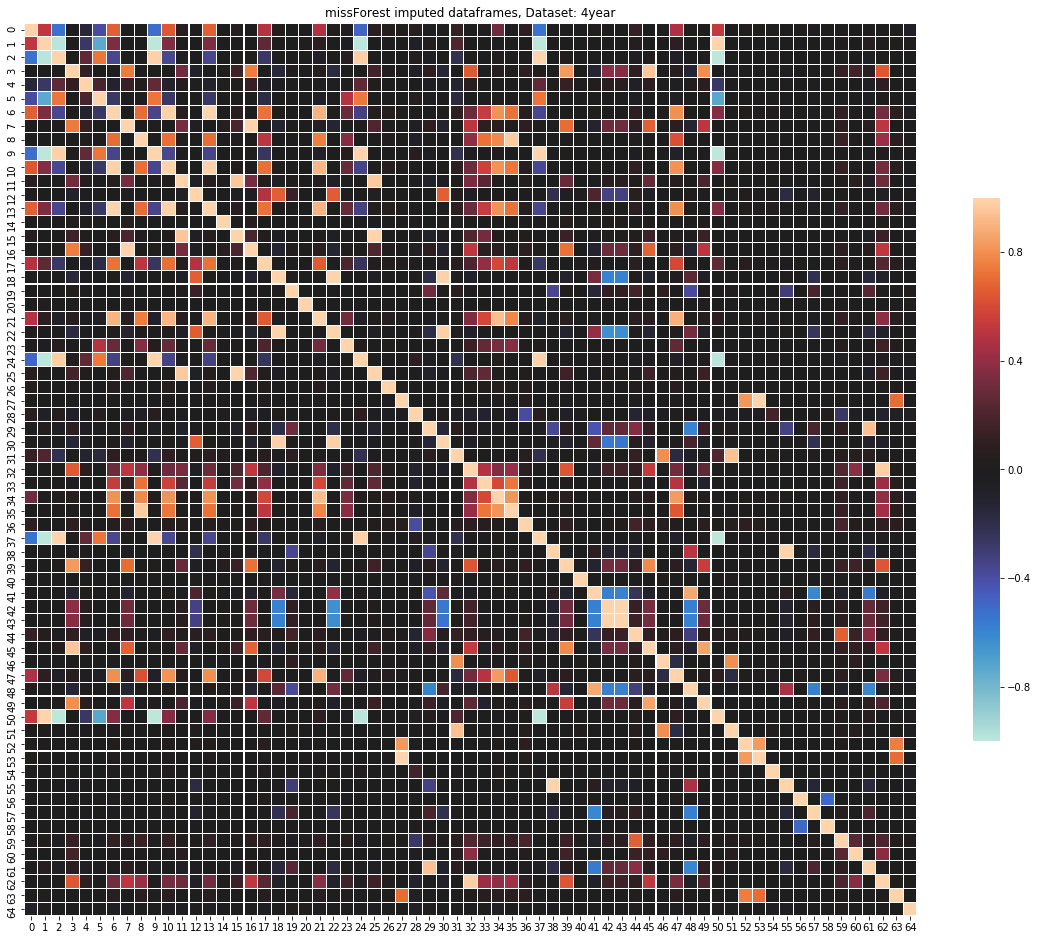

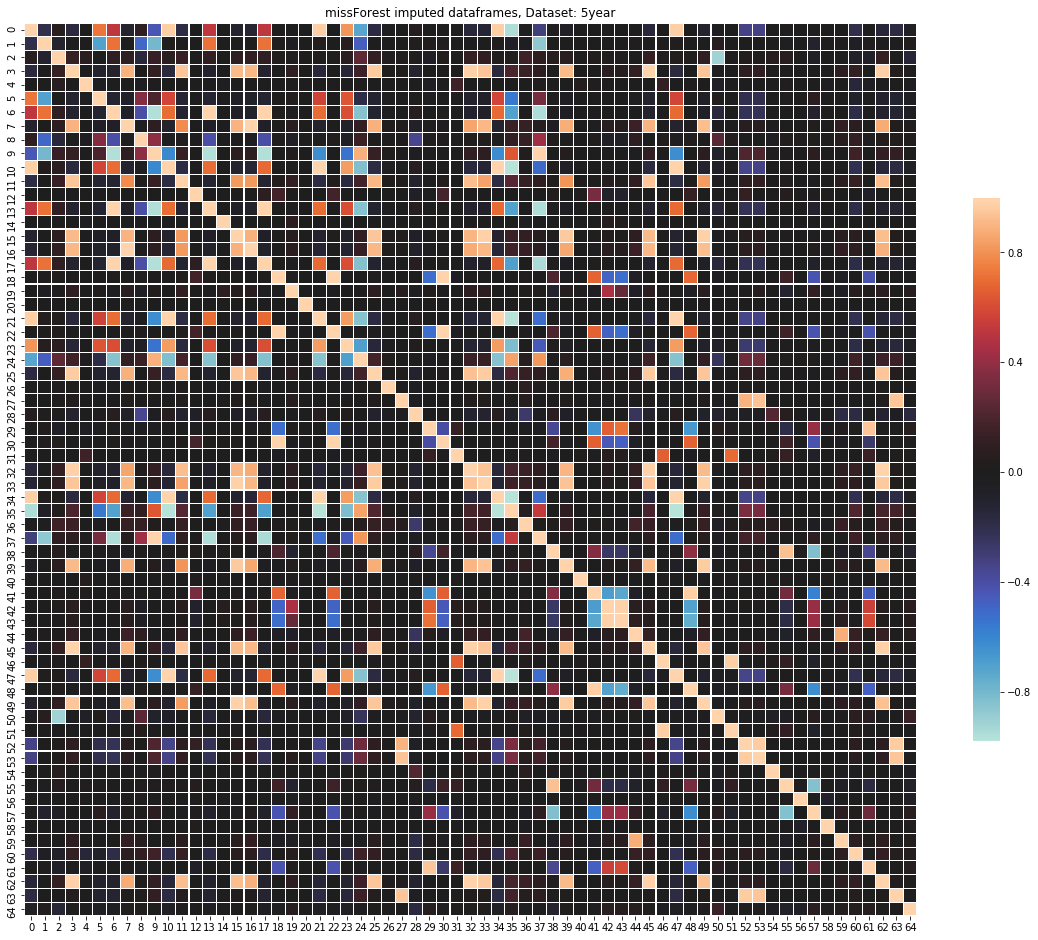

In [510]:
#Creating heatmap to detect Multicollinearity
def correlation_heatmap(df_dict):
    for key,dfs in df_dict.items():
        for i in range(5):
            correlations = dfs[i].corr()
            fig, ax = plt.subplots(figsize=(20,20))
            sns_plot = sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                    square=True, linewidths=.1, annot=False, 
                        cbar_kws={"shrink": .50}).set_title(key + ' imputed dataframes, '+'Dataset: '+str(i+1)+'year')
            # save heatmap as a png file for external use
            fig = sns_plot.get_figure()
            fig.savefig(key + ' imputed dataframes, '+'Dataset: '+str(i+1)+'year'+ 'heatmap.png')
correlation_heatmap(imputed_dataframes_dictionary)

#### Above heatmap from the correlation analysis shows that a lot of features are correlated with each other, which would not be good for prediction model building. However, it would be considered as a better approach to eliminate these negative factors with feature selection methods, rather than to remove every correlated features.
#### Therefore, I would like to choose sophisticated feature selection principle, which could consider correlation effect of each feature during the feature selection process.

## 3-D. Feature Selection via Boruta

#### The Boruta algorithm is a wrapper built around the random forest classification algorithm. It tries to capture all the important, interesting features with respect to an outcome variable.

In [124]:
# Split the features and labels into separate dataframes for all the original dataframes
def split_dataframes_features_labels(dfs):
    feature_dfs = [dfs[i].iloc[:,0:64] for i in range(len(dfs))]
    label_dfs = [dfs[i].iloc[:,64] for i in range(len(dfs))]
    return feature_dfs, label_dfs

# Feature selection with Boruta 
def feature_select_boruta(dfs):
    rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')
    boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
    #Split the features and labels for each dataframe
    feature_dfs, label_dfs = split_dataframes_features_labels(dfs)
    filtered_feature_arrays = []
    filtered_label_arrays = []
    for i in range(5):
        x=feature_dfs[i].values
        y=label_dfs[i].values
        boruta_selector.fit(x,y)
        print('==============BORUTA==============')
        print('Dataset: '+str(i+1)+'year')
        # Check selected features
        print(boruta_selector.support_)
        # Select the chosen features from our dataframe.
        selected = x[:, boruta_selector.support_]
        print ("")
        print ("Selected Feature Matrix Shape")
        print (selected.shape)
        # check ranking of features
        boruta_selector.ranking_

        # call transform() on X to filter it down to selected features
        X_filtered = boruta_selector.transform(x)
        # Append the filtered feature and label arrays of ith dataframe
        filtered_feature_arrays.append(X_filtered)
        filtered_label_arrays.append(y)
    return filtered_feature_arrays, filtered_label_arrays 

# Utility Function to convert the arrays of features and labels to pandas dataframes, and then join them.
def restructure_arrays_to_dataframes(feature_arrays, label_arrays):
    resampled_dfs = []
    for i in range(len(feature_arrays)):
        feature_df = pd.DataFrame(data=feature_arrays[i])
        label_df = pd.DataFrame(data=label_arrays[i])
        # Must set the column header for label_df, otherwise it wont join with feature_df, as columns overlap (with col names '0')
        label_df.columns=['class'] 
        resampled_dfs.append(feature_df.join(label_df))
    return resampled_dfs

# Perform Boruta feature selection on all the imputed dataframes, and return them in a dictionary.
def perform_boruta_on_imputed_dataframes(df_dict):
    imputed_feature_selected_dataframes_dictionary = OrderedDict()
    for key,dfs in df_dict.items():
        print('Feature selection via Boruta for ' + key + ' imputed dataframes\n')
        filtered_feature_arrays, filtered_label_arrays = feature_select_boruta(dfs)
        filtered_dataframes = restructure_arrays_to_dataframes(filtered_feature_arrays, filtered_label_arrays)
        imputed_feature_selected_dataframes_dictionary[key] = filtered_dataframes
        print('-'*50)
    return imputed_feature_selected_dataframes_dictionary

imputed_feature_selected_dataframes_dictionary = perform_boruta_on_imputed_dataframes(imputed_dataframes_dictionary)

Feature selection via Boruta for k-NN imputed dataframes

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	19
Rejected: 	35
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	19
Rejected: 	35
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	19
Rejected: 	35
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	19
Rejected: 	35
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	15
Rejected: 	39
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	15
Rejected: 	39
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	15
Rejected: 	39
Iteration: 	15 / 100
Confirmed: 	10
Tentative: 	15
Reje

Iteration: 	21 / 100
Confirmed: 	11
Tentative: 	13
Rejected: 	40
Iteration: 	22 / 100
Confirmed: 	11
Tentative: 	13
Rejected: 	40
Iteration: 	23 / 100
Confirmed: 	11
Tentative: 	13
Rejected: 	40
Iteration: 	24 / 100
Confirmed: 	11
Tentative: 	13
Rejected: 	40
Iteration: 	25 / 100
Confirmed: 	11
Tentative: 	13
Rejected: 	40
Iteration: 	26 / 100
Confirmed: 	12
Tentative: 	12
Rejected: 	40
Iteration: 	27 / 100
Confirmed: 	12
Tentative: 	12
Rejected: 	40
Iteration: 	28 / 100
Confirmed: 	12
Tentative: 	12
Rejected: 	40
Iteration: 	29 / 100
Confirmed: 	12
Tentative: 	12
Rejected: 	40
Iteration: 	30 / 100
Confirmed: 	12
Tentative: 	12
Rejected: 	40
Iteration: 	31 / 100
Confirmed: 	12
Tentative: 	12
Rejected: 	40
Iteration: 	32 / 100
Confirmed: 	12
Tentative: 	11
Rejected: 	41
Iteration: 	33 / 100
Confirmed: 	12
Tentative: 	11
Rejected: 	41
Iteration: 	34 / 100
Confirmed: 	12
Tentative: 	11
Rejected: 	41
Iteration: 	35 / 100
Confirmed: 	12
Tentative: 	11
Rejected: 	41
Iteration: 	36 / 100
Conf

Iteration: 	40 / 100
Confirmed: 	13
Tentative: 	10
Rejected: 	41
Iteration: 	41 / 100
Confirmed: 	13
Tentative: 	10
Rejected: 	41
Iteration: 	42 / 100
Confirmed: 	13
Tentative: 	10
Rejected: 	41
Iteration: 	43 / 100
Confirmed: 	13
Tentative: 	10
Rejected: 	41
Iteration: 	44 / 100
Confirmed: 	13
Tentative: 	10
Rejected: 	41
Iteration: 	45 / 100
Confirmed: 	13
Tentative: 	10
Rejected: 	41
Iteration: 	46 / 100
Confirmed: 	14
Tentative: 	9
Rejected: 	41
Iteration: 	47 / 100
Confirmed: 	14
Tentative: 	9
Rejected: 	41
Iteration: 	48 / 100
Confirmed: 	14
Tentative: 	9
Rejected: 	41
Iteration: 	49 / 100
Confirmed: 	14
Tentative: 	9
Rejected: 	41
Iteration: 	50 / 100
Confirmed: 	14
Tentative: 	9
Rejected: 	41
Iteration: 	51 / 100
Confirmed: 	15
Tentative: 	8
Rejected: 	41
Iteration: 	52 / 100
Confirmed: 	15
Tentative: 	8
Rejected: 	41
Iteration: 	53 / 100
Confirmed: 	15
Tentative: 	8
Rejected: 	41
Iteration: 	54 / 100
Confirmed: 	15
Tentative: 	8
Rejected: 	41
Iteration: 	55 / 100
Confirmed: 	1

Iteration: 	60 / 100
Confirmed: 	20
Tentative: 	10
Rejected: 	34
Iteration: 	61 / 100
Confirmed: 	20
Tentative: 	10
Rejected: 	34
Iteration: 	62 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	63 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	64 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	65 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	66 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	67 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	68 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	69 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	70 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	71 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	72 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	73 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	74 / 100
Confirmed: 	21
Tentative: 	9
Rejected: 	34
Iteration: 	75 / 100
Confirmed: 	21
Te

Iteration: 	80 / 100
Confirmed: 	28
Tentative: 	14
Rejected: 	22
Iteration: 	81 / 100
Confirmed: 	28
Tentative: 	14
Rejected: 	22
Iteration: 	82 / 100
Confirmed: 	28
Tentative: 	14
Rejected: 	22
Iteration: 	83 / 100
Confirmed: 	29
Tentative: 	13
Rejected: 	22
Iteration: 	84 / 100
Confirmed: 	29
Tentative: 	13
Rejected: 	22
Iteration: 	85 / 100
Confirmed: 	29
Tentative: 	13
Rejected: 	22
Iteration: 	86 / 100
Confirmed: 	29
Tentative: 	13
Rejected: 	22
Iteration: 	87 / 100
Confirmed: 	29
Tentative: 	13
Rejected: 	22
Iteration: 	88 / 100
Confirmed: 	29
Tentative: 	13
Rejected: 	22
Iteration: 	89 / 100
Confirmed: 	29
Tentative: 	13
Rejected: 	22
Iteration: 	90 / 100
Confirmed: 	29
Tentative: 	13
Rejected: 	22
Iteration: 	91 / 100
Confirmed: 	29
Tentative: 	13
Rejected: 	22
Iteration: 	92 / 100
Confirmed: 	29
Tentative: 	13
Rejected: 	22
Iteration: 	93 / 100
Confirmed: 	30
Tentative: 	12
Rejected: 	22
Iteration: 	94 / 100
Confirmed: 	30
Tentative: 	12
Rejected: 	22
Iteration: 	95 / 100
Conf

Iteration: 	97 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	38
Iteration: 	98 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	38
Iteration: 	99 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	38


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	17
Tentative: 	3
Rejected: 	38
==============BORUTA==============
Dataset: 1year
[False False False False  True  True False False  True False False  True
  True False False  True False False  True False False False  True  True
 False  True  True False  True False False False False  True False False
 False  True False False  True False False False  True  True False False
 False False False False False False False False False False False False
 False False False False]

Selected Feature Matrix Shape
(7027, 17)
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative:

Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	20
Rejected: 	32
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	20
Rejected: 	32
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	20
Rejected: 	32
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	20
Rejected: 	32
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	18
Rejected: 	34
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	18
Rejected: 	34
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	18
Rejected: 	34
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	14
Rejected: 	38
Iteration: 	17 / 100
Confirmed: 	12
Tentative: 	14
Rejected: 	38
Iteration: 	18 / 100
Confirmed: 	12
Tentative: 	14
Rejected: 	38
Iteration: 	19 / 100
Confirmed: 	13
Tentative: 	13
Rejected: 	38
Iteration: 	20 / 100
Confirmed: 	13
Tentative: 	12
Rejected: 	39
Iteration: 	21 / 100
Confirmed: 	13
Tentative: 	12
Rejected: 	39
Iteration: 	22 / 100
Confirmed: 	13
Tentative: 	12
Rejected: 	39
Iteration: 	23 / 100
Confirmed: 	13
Tentative: 	12
Rejected: 	39
Iteration: 	24 / 100
Confi

Iteration: 	29 / 100
Confirmed: 	17
Tentative: 	13
Rejected: 	34
Iteration: 	30 / 100
Confirmed: 	17
Tentative: 	13
Rejected: 	34
Iteration: 	31 / 100
Confirmed: 	17
Tentative: 	13
Rejected: 	34
Iteration: 	32 / 100
Confirmed: 	19
Tentative: 	11
Rejected: 	34
Iteration: 	33 / 100
Confirmed: 	19
Tentative: 	11
Rejected: 	34
Iteration: 	34 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	35
Iteration: 	35 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	35
Iteration: 	36 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	35
Iteration: 	37 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	35
Iteration: 	38 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	35
Iteration: 	39 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	35
Iteration: 	40 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	35
Iteration: 	41 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	35
Iteration: 	42 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	35
Iteration: 	43 / 100
Confirmed: 	21
Tentative: 	8
Rejected: 	35
Iteration: 	44 / 100
Confirmed: 	21

Iteration: 	49 / 100
Confirmed: 	28
Tentative: 	15
Rejected: 	21
Iteration: 	50 / 100
Confirmed: 	28
Tentative: 	15
Rejected: 	21
Iteration: 	51 / 100
Confirmed: 	28
Tentative: 	15
Rejected: 	21
Iteration: 	52 / 100
Confirmed: 	28
Tentative: 	15
Rejected: 	21
Iteration: 	53 / 100
Confirmed: 	28
Tentative: 	15
Rejected: 	21
Iteration: 	54 / 100
Confirmed: 	28
Tentative: 	15
Rejected: 	21
Iteration: 	55 / 100
Confirmed: 	28
Tentative: 	15
Rejected: 	21
Iteration: 	56 / 100
Confirmed: 	28
Tentative: 	15
Rejected: 	21
Iteration: 	57 / 100
Confirmed: 	28
Tentative: 	15
Rejected: 	21
Iteration: 	58 / 100
Confirmed: 	28
Tentative: 	15
Rejected: 	21
Iteration: 	59 / 100
Confirmed: 	28
Tentative: 	14
Rejected: 	22
Iteration: 	60 / 100
Confirmed: 	28
Tentative: 	14
Rejected: 	22
Iteration: 	61 / 100
Confirmed: 	28
Tentative: 	14
Rejected: 	22
Iteration: 	62 / 100
Confirmed: 	28
Tentative: 	14
Rejected: 	22
Iteration: 	63 / 100
Confirmed: 	28
Tentative: 	14
Rejected: 	22
Iteration: 	64 / 100
Conf

#### As a result of Boruta feature selection, several features were selected for each dataset according to the calculation result for importance.
#### For example, in case of K-NN imputed 1year dataset has only 14 features, but 3year dataset has 17 features as an important features.
#### Therefore, only selected features of each dataset should be applied for further processes.

## 3-E. Dealing with imbalanced data

### 3-E-1. Check out whether dataset is imbalanced

In [88]:
# check out data imbalance via counting numbers
def check_data_imbalance(dfs):
    for i in range(len(dfs)):
        print('Dataset: '+str(i+1)+'year')
        print(dfs[i].groupby('class').size())
        minority_percent = (dfs[i]['class'].tolist().count(1) / len(dfs[i]['class'].tolist()))*100
        print('Minority (label 1) percentage: '+  str(minority_percent) + ' %')
        print('-'*64)
        
check_data_imbalance(dataframes)

Dataset: 1year
class
0    6756
1     271
dtype: int64
Minority (label 1) percentage: 3.856553294435748 %
----------------------------------------------------------------
Dataset: 2year
class
0    9773
1     400
dtype: int64
Minority (label 1) percentage: 3.931976801336872 %
----------------------------------------------------------------
Dataset: 3year
class
0    10008
1      495
dtype: int64
Minority (label 1) percentage: 4.712939160239932 %
----------------------------------------------------------------
Dataset: 4year
class
0    9277
1     515
dtype: int64
Minority (label 1) percentage: 5.259395424836601 %
----------------------------------------------------------------
Dataset: 5year
class
0    5500
1     410
dtype: int64
Minority (label 1) percentage: 6.937394247038917 %
----------------------------------------------------------------


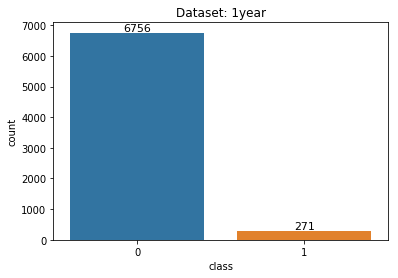

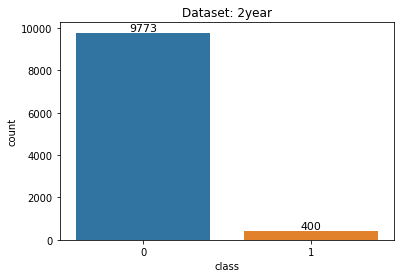

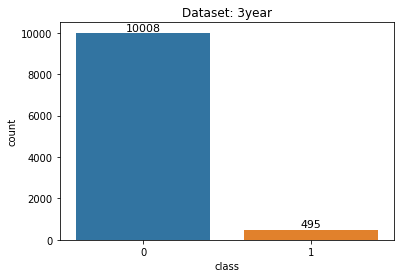

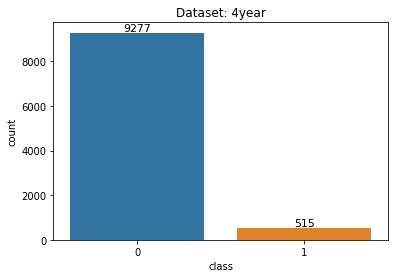

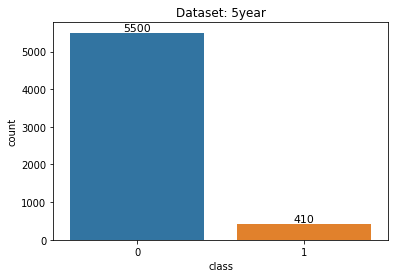

<Figure size 432x288 with 0 Axes>

In [520]:
# showing dataset is imbalanced via bar chart
def bar_plot_imbalance(dfs):
    for i in range(len(dfs)):
        ax = sns.countplot(dfs[i]['class'])
        ax.set_title('Dataset: '+str(i+1)+'year')
        #annotate axis = seaborn axis
        for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                 textcoords='offset points')
        plt.figure()
         
bar_plot_imbalance(dataframes)

#### As result of counting shows, number of data for each class(0(non-bankrupted),1(backrupted)) is imbalanced. Thus, we need balancing technique to make the number of data for each class same 
#### For this analysis, I would like to introduce SMOTE sampling technique, which is the one of well known approach, due to their benefit especially for high dimensional data and no loss of data through the oversampling.

### 3-E-2. Oversampling with SMOTE (Synthetic Minority Over Sampling Technique)

SMOTE Oversampling for k-NN imputed dataframes

Dataset: 1year:
Original dataset shape Counter({0.0: 6756, 1.0: 271})
Resampled dataset shape Counter({0.0: 6756, 1.0: 6756})

Dataset: 2year:
Original dataset shape Counter({0.0: 9773, 1.0: 400})
Resampled dataset shape Counter({0.0: 9773, 1.0: 9773})

Dataset: 3year:
Original dataset shape Counter({0.0: 10008, 1.0: 495})
Resampled dataset shape Counter({0.0: 10008, 1.0: 10008})

Dataset: 4year:
Original dataset shape Counter({0.0: 9277, 1.0: 515})
Resampled dataset shape Counter({0.0: 9277, 1.0: 9277})

Dataset: 5year:
Original dataset shape Counter({0.0: 5500, 1.0: 410})
Resampled dataset shape Counter({0.0: 5500, 1.0: 5500})

--------------------------------------------------
SMOTE Oversampling for missForest imputed dataframes

Dataset: 1year:
Original dataset shape Counter({0.0: 6756, 1.0: 271})
Resampled dataset shape Counter({0.0: 6756, 1.0: 6756})

Dataset: 2year:
Original dataset shape Counter({0.0: 9773, 1.0: 400})
Resampled da

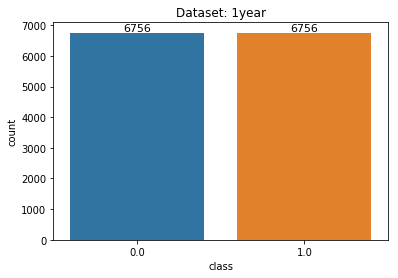

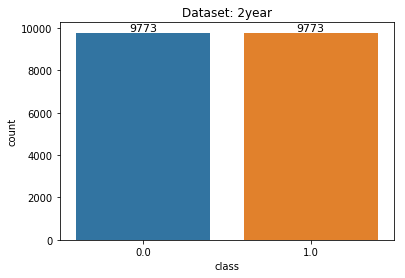

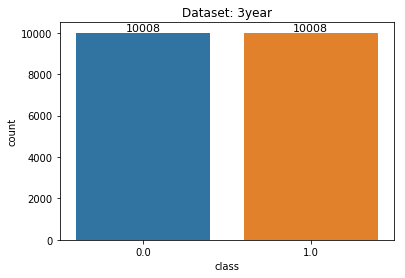

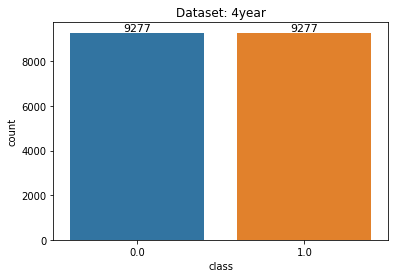

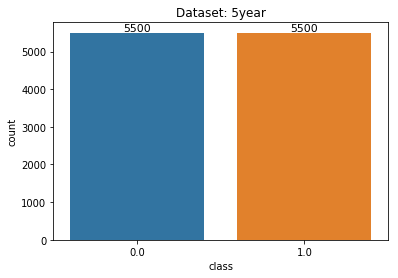

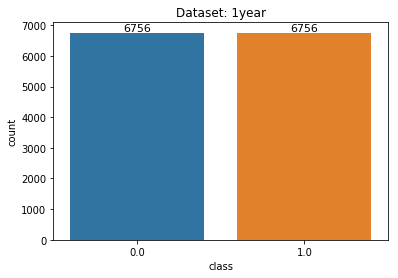

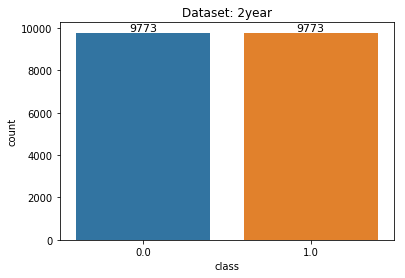

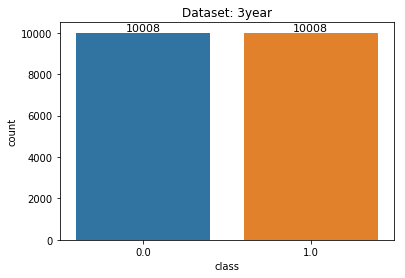

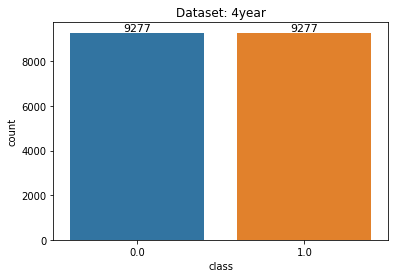

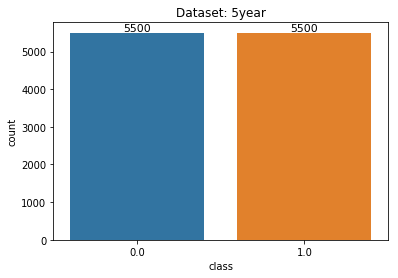

<Figure size 432x288 with 0 Axes>

In [525]:
# Split the features and labels into separate dataframes for all the original dataframes
def split_dataframes_features_labels(dfs):
    feature_dfs = [dfs[i].iloc[:,0:len(dfs[i].columns)-1] for i in range(len(dfs))]
    label_dfs = [dfs[i].iloc[:,len(dfs[i].columns)-1] for i in range(len(dfs))]
    return feature_dfs, label_dfs

# Performs the SMOTE oversampling for given dataframes.
def oversample_data_SMOTE(dfs, verbose=False):
    smote = SMOTE(sampling_strategy='auto' , random_state=42, k_neighbors=10)
    #Split the features and labels for each dataframe
    feature_dfs, label_dfs = split_dataframes_features_labels(dfs)
    resampled_feature_arrays = []
    resampled_label_arrays = []
    for i in range(len(dfs)):
        if verbose: print('Dataset: ' + str(i+1) + 'year:')
        if verbose: print('Original dataset shape {}'.format(Counter(label_dfs[i])))
        dfi_features_res, dfi_label_res = smote.fit_sample(feature_dfs[i], label_dfs[i])
        if verbose: print('Resampled dataset shape {}\n'.format(Counter(dfi_label_res)))
        # Append the resampled feature and label arrays of ith dataframe to their respective list of arrays    
        resampled_feature_arrays.append(dfi_features_res)
        resampled_label_arrays.append(dfi_label_res)        
    return resampled_feature_arrays, resampled_label_arrays

# Utility Function to convert the arrays of features and labels to pandas dataframes, and then join them.
def restructure_arrays_to_dataframes(feature_arrays, label_arrays):
    resampled_dfs = []
    for i in range(len(feature_arrays)):
        feature_df = pd.DataFrame(data=feature_arrays[i])
        label_df = pd.DataFrame(data=label_arrays[i])
        # Must set the column header for label_df, otherwise it wont join with feature_df, as columns overlap (with col names '0')
        label_df.columns=['class'] 
        resampled_dfs.append(feature_df.join(label_df))
    return resampled_dfs

# Perform SMOTE oversampling on all the imputed dataframes, and return them in a dictionary.
def perform_oversampling_on_imputed_dataframes(df_dict):
    imputed_oversampled_dataframes_dictionary = OrderedDict()
    for key,dfs in df_dict.items():
        print('SMOTE Oversampling for ' + key + ' imputed dataframes\n')
        smote_feature_arrays, smote_label_arrays = oversample_data_SMOTE(dfs, verbose=True)
        oversampled_dataframes = restructure_arrays_to_dataframes(smote_feature_arrays, smote_label_arrays)
        imputed_oversampled_dataframes_dictionary[key] = oversampled_dataframes
        bar_plot_imbalance(imputed_oversampled_dataframes_dictionary[key]) # showing balanced result via bar chart
        print('-'*50)
    return imputed_oversampled_dataframes_dictionary

imputed_oversampled_dataframes_dictionary = perform_oversampling_on_imputed_dataframes(imputed_feature_selected_dataframes_dictionary)

# 4. Model Building

## 4-A.  K-Fold Cross Validation
#### Since our dataset has relatively low number of data(e.g. 7027 for 1year dataset and 5910 for 5year dataset), it would be quite hard to simply split into the trainset and testset with 80:20 or 70:30 proportion.
#### In this case K-fold cross validation approach could be beneficial, since we can use every data for training and testing.  In addition, it reduce the risk of bias from certain part of dataset.
#### Therefore, I would like to use K-fold cross validation instead of splitting the dataset into train and testset

In [187]:
def prepare_kfold_cv_data(k, X, y, verbose=False):
    X = X.values
    y = y.values
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test

## 4-B. Preparation of classification models

### 4-B-1. Gaussian Naive Bayes classifier

In [128]:
# Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

### 4-B-2. Logistic Regression classifier

In [137]:
# Logistic Regression classifier
lr_classifier = LogisticRegression(penalty = 'l2', random_state = 0)

### 4-B-3. Decision Tree Classifier

In [130]:
# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

### 4-B-4. Random Forest Classifier

In [131]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')

### 4-B-5. Balanced Bagging Classifier

In [133]:
# Balanced Bagging Classifier
bb_classifier = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='entropy'), 
                                          n_estimators = 5, bootstrap = True)

In [138]:
# creating a dictionary of models
models_dictionary = OrderedDict()

models_dictionary['Gaussian Naive Bayes'] = gnb_classifier
models_dictionary['Logistic Regression'] = lr_classifier
models_dictionary['Decision Tree'] = dt_classifier
models_dictionary['Random Forest'] = rf_classifier
models_dictionary['Balanced Bagging'] = bb_classifier

## 4-C. Building a prediction model
For each of ....
- 5 Models(Gaussian Naive Bayes, Logistic Regression, Decision Tree, Random Forests, Balanced Bagging)
- 2 Imputers(k-NN, Random Forests(missForest))
- 5 Datasets (1year, 2year, 3year, 4year, 5year)
- 8 metrics (Accuracy, Precision, Recall, AUC, True Positive(TP), True Negative(TN), False Positive(FP), False Negative(FN))
    - For 8 metrics, it should be averaged over all the k-folds



In [198]:
# perform data modeling
def perform_data_modeling(_models_, _imputers_, verbose=False, k_folds=5):
    
    # 5 Models
    # 2 Imputers
    # 5 datasets (for 5 years)
    # 8 metrics, averaged over all the K-Folds
    model_results = OrderedDict()
    
    # Iterate over the models
    for model_name, clf in _models_.items():
        if verbose: print("-"*100, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()
        
        # Iterate over the different imputed_data mechanisms (Mean, k-NN, EM, MICE)
        for imputer_name, dataframes_list in _imputers_.items():
            if verbose: print("\n", '\tImputer Technique: ' + '\033[1m' + imputer_name + '\033[0m')
            
            # call the split_dataframes_features_labels function to get a list of features and labels for all the dataframes
            feature_dfs, label_dfs = split_dataframes_features_labels(dataframes_list)            
            
            year_results = OrderedDict()
            
            # Iterate over dataframe_list individually
            for df_index in range(len(dataframes_list)):
                if verbose: print('\t\t\tDataset: ' + '\033[1m' + str(df_index+1) + 'year' + '\033[0m')
                
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
                X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, feature_dfs[df_index], label_dfs[df_index], verbose)
                
                metrics_results = OrderedDict()
                accuracy_list = np.zeros([k_folds])
                precision_list = np.zeros([k_folds,2])
                recall_list = np.zeros([k_folds,2])
                AUC_list = np.zeros([k_folds])
                TN_list = np.zeros([k_folds])
                FP_list = np.zeros([k_folds])
                FN_list = np.zeros([k_folds])
                TP_list = np.zeros([k_folds])                
                
                # Iterate over all the k-folds
                for k_index in range(k_folds):
                    X_train = X_train_list[k_index]
                    y_train = y_train_list[k_index]
                    X_test = X_test_list[k_index]
                    y_test = y_test_list[k_index]
                    
                    # Fit the model and 
                    clf = clf.fit(X_train, y_train)
                    # save the model to disk (for later use..)
                    filename = model_name + '_' + imputer_name + '_' + str(df_index+1) + 'year'+'.sav'
                    pickle.dump(clf, open(filename, 'wb'))
                    # predict 0 or 1 with testset
                    y_test_predicted = clf.predict(X_test)
                    
                    #code for calculating accuracy 
                    _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
                    accuracy_list[k_index] = _accuracy_
                    
                    #code for calculating recall 
                    _recalls_ = recall_score(y_test, y_test_predicted, average=None)
                    recall_list[k_index] = _recalls_
                    
                    #code for calculating precision 
                    _precisions_ = precision_score(y_test, y_test_predicted, average=None)
                    precision_list[k_index] = _precisions_
                    
                    #code for calculating AUC
                    fpr, tpr, thresholds = roc_curve(y_test, y_test_predicted)
                    _AUC_ = auc(fpr, tpr)
                    print(str(k_index)+'fold AUC: ', _AUC_)
                    AUC_list[k_index] = _AUC_
                    
                    #code for calculating confusion matrix 
                    _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
                    TN_list[k_index] = _confusion_matrix_[0][0]
                    FP_list[k_index] = _confusion_matrix_[0][1]
                    FN_list[k_index] = _confusion_matrix_[1][0]
                    TP_list[k_index] = _confusion_matrix_[1][1]
                    print(_confusion_matrix_)
                
                # creating a metrics dictionary
                metrics_results['Accuracy'] = np.mean(accuracy_list)
                metrics_results['Precisions'] = np.mean(precision_list, axis=0)
                metrics_results['Recalls'] = np.mean(recall_list, axis=0)
                metrics_results['AUC'] = np.mean(AUC_list)
                metrics_results['TN'] = np.mean(TN_list)
                metrics_results['FP'] = np.mean(FP_list)
                metrics_results['FN'] = np.mean(FN_list)
                metrics_results['TP'] = np.mean(TP_list)
                
                if verbose:
                    print('\t\t\tAccuracy:', metrics_results['Accuracy'])
                    print('\t\t\tAUC:', metrics_results['AUC'])
                    print('\t\t\tPrecision:', metrics_results['Precisions'])
                    print('\t\t\tRecall:', metrics_results['Recalls'])
                
                year_results[str(df_index+1)+'year'] = metrics_results   
                
            imputer_results[imputer_name] = year_results
            
        model_results[model_name] = imputer_results  
        
    return model_results

In [202]:
results = perform_data_modeling(models_dictionary, imputed_oversampled_dataframes_dictionary, verbose=True, k_folds=5)

---------------------------------------------------------------------------------------------------- 
 Model: Gaussian Naive Bayes Classifier

 	Imputer Technique: k-NN
			Dataset: 1year
0fold AUC:  0.5021089561652475
[[  30 1329]
 [  24 1320]]
1fold AUC:  0.5043860898138006
[[  30 1298]
 [  19 1356]]
2fold AUC:  0.504755437763551
[[  40 1356]
 [  25 1281]]
3fold AUC:  0.5058394720477327
[[  33 1324]
 [  17 1328]]
4fold AUC:  0.5008212827361763
[[  24 1292]
 [  23 1363]]
			Accuracy: 0.5036260393296041
			AUC: 0.5035822477053017
			Precision: [0.59076467 0.50182652]
			Recall: [0.02317483 0.98398967]
			Dataset: 2year
0fold AUC:  0.508054885732347
[[  61 1905]
 [  29 1915]]
1fold AUC:  0.5070238587636584
[[  70 1894]
 [  42 1903]]
2fold AUC:  0.506072914239639
[[  58 1881]
 [  35 1935]]
3fold AUC:  0.5081801082562406
[[  65 1931]
 [  31 1882]]
4fold AUC:  0.5112864165401576
[[  65 1843]
 [  23 1978]]
			Accuracy: 0.5081347981149148
			AUC: 0.5081236367064086
			Precision: [0.66843068 0

[[1758  275]
 [1321  649]]
4fold AUC:  0.5923669679404412
[[1683  275]
 [1380  665]]
			Accuracy: 0.5967725629354408
			AUC: 0.5967737456071264
			Precision: [0.56284022 0.71028041]
			Recall: [0.8665863 0.3269612]
			Dataset: 4year
0fold AUC:  0.660464721056974
[[1319  561]
 [ 697 1134]]
1fold AUC:  0.6496436713096583
[[1408  431]
 [ 873  999]]
2fold AUC:  0.6660741391359205
[[1360  497]
 [ 742 1112]]
3fold AUC:  0.662320530732342
[[1346  519]
 [ 733 1113]]
4fold AUC:  0.6721589204874407
[[1365  471]
 [ 748 1126]]
			Accuracy: 0.6619601955576087
			AUC: 0.662132396544467
			Precision: [0.64239389 0.68915955]
			Recall: [0.73295463 0.59131017]
			Dataset: 5year
0fold AUC:  0.7165387260152604
[[698 410]
 [215 877]]
1fold AUC:  0.733374677002584
[[793 332]
 [256 819]]
2fold AUC:  0.7144344747392353
[[651 448]
 [180 921]]
3fold AUC:  0.7316282191479637
[[736 351]
 [238 875]]
4fold AUC:  0.7288042134884871
[[713 368]
 [226 893]]
			Accuracy: 0.7250909090909091
			AUC: 0.7249560620787061
		

0fold AUC:  0.9449913933564597
[[1256  103]
 [  46 1298]]
1fold AUC:  0.9441933187294632
[[1230   98]
 [  52 1323]]
2fold AUC:  0.9510431247449506
[[1301   95]
 [  39 1267]]
3fold AUC:  0.9456523108869609
[[1266   91]
 [  56 1289]]
4fold AUC:  0.9411401246507629
[[1219   97]
 [  61 1325]]
			Accuracy: 0.9453819850356802
			AUC: 0.9454040544737194
			Precision: [0.96099747 0.93072188]
			Recall: [0.92831886 0.96248924]
			Dataset: 2year
0fold AUC:  0.9361284323206444
[[1817  149]
 [ 101 1843]]
1fold AUC:  0.9271928125278143
[[1780  184]
 [ 101 1844]]
2fold AUC:  0.9256980022671165
[[1767  172]
 [ 118 1852]]
3fold AUC:  0.9311800548299946
[[1835  161]
 [ 109 1804]]
4fold AUC:  0.921382469142787
[[1731  177]
 [ 129 1872]]
			Accuracy: 0.9283225345929356
			AUC: 0.9283163542176714
			Precision: [0.94112437 0.91623467]
			Recall: [0.91367822 0.94295449]
			Dataset: 3year
0fold AUC:  0.9128371628371629
[[1780  222]
 [ 127 1875]]
1fold AUC:  0.9149362557717811
[[1819  200]
 [ 141 1843]]
2fold

# 5. Model Analysis

## 5-A. Model Ranking
#### Which model shows better performance? 

In [413]:
def perform_model_ranking(models, imputers, results):
    column_headers = ['Imputer', 'Model', 'Data set(Year)', 'Accuracy', 'AUC', 'Precision', 'Recalls']
    rows = pd.DataFrame()
    
    for model_name, model_details in results.items():    
        for imputer_name, imputer_details in model_details.items():                
            for year, metrics in imputer_details.items():
                row = [] 
                row.append(imputer_name)
                row.append(model_name)
                row.append(year)
                accuracy = metrics['Accuracy']
                row.append(accuracy)
                auc = metrics['AUC']
                row.append(auc)
                precision = metrics['Precisions'][0]
                row.append(precision)
                recall = metrics['Recalls'][0]
                row.append(recall)                   
                row_df = pd.DataFrame(data=row).T
                rows = pd.concat([row_df, rows])
    results_df = rows
    results_df.columns = column_headers
    results_df.to_csv ('results_df.csv', index = False, header=True)
    return results_df

In [414]:
perform_model_ranking(models_dictionary, imputed_oversampled_dataframes_dictionary, results)

,Imputer,Model,Data set(Year),Accuracy,AUC,Precision,Recalls
0,missForest,Balanced Bagging,5year,0.943909,0.94388,0.961381,0.925107
0,missForest,Balanced Bagging,4year,0.946427,0.946399,0.975485,0.915901
0,missForest,Balanced Bagging,3year,0.944794,0.944787,0.968469,0.919565
0,missForest,Balanced Bagging,2year,0.962806,0.962789,0.979311,0.945516
0,missForest,Balanced Bagging,1year,0.965734,0.965731,0.980557,0.950227
0,k-NN,Balanced Bagging,5year,0.947636,0.947619,0.968894,0.925163
0,k-NN,Balanced Bagging,4year,0.945942,0.945941,0.975231,0.91518
0,k-NN,Balanced Bagging,3year,0.946593,0.946583,0.965909,0.925843
0,k-NN,Balanced Bagging,2year,0.949401,0.949404,0.966992,0.930496
0,k-NN,Balanced Bagging,1year,0.955965,0.955933,0.971778,0.939095


#### According to the result, "Balaned Bagging Model" shows the highest preformance to predict the bankruptcy, regardress of imputer type and dataset.
#### Therefore, let's calculate the probability of bankruptcy by using this highly performed model!

# 6. Calculate the probability of backuptcy using selected model
### Q. What is the probability of bankruptcy after 1, 2, 3 years?

### 6-A. Import the selected Model
#### Among the every trained model, I would like to only import the selected model, which shows the highest performance. - Balanced Bagging Model!

In [440]:
# Using pre-trained model with imputed & balanced(with SMOTE sampling) data set

# import the model from the disk
filename = 'Balanced Bagging_missForest_5year.sav'
loaded_model_5year = pickle.load(open(filename, 'rb'))
filename = 'Balanced Bagging_missForest_4year.sav'
loaded_model_4year = pickle.load(open(filename, 'rb'))
filename = 'Balanced Bagging_missForest_3year.sav'
loaded_model_3year = pickle.load(open(filename, 'rb'))
filename = 'Balanced Bagging_missForest_2year.sav'
loaded_model_2year = pickle.load(open(filename, 'rb'))
filename = 'Balanced Bagging_missForest_1year.sav'
loaded_model_1year = pickle.load(open(filename, 'rb'))

### 6-B. Calculate the chance of bankruptcy by using the selected model

In [506]:
# Test with selected model to calculate the probability of bankruptcy
def testing_selected_model(df_dict):
    
    for key, dfs in df_dict.items():
        if key.startswith('missForest'): 
            
            ############ Prediction of bankuptcy ########################
            
            # 1. What's the probability of bankruptcy after 1 year?
            
            data = dfs[4] # choose the same dataset with model training to apply same features with the selected model
            # split the dataframe with features and label
            label_dfs = data[data.columns[-1]]
            feature_dfs = data[data.columns[:(data.shape[1]-1)]]
            # split data into train and test set
            X_train, X_test, y_train, y_test = train_test_split(feature_dfs, label_dfs, test_size=0.2, random_state=42)
            
            # prediction with test dataset
            y_predicted_after_1year = loaded_model_5year.predict(X_test)
            y_probability_after_1year = loaded_model_5year.predict_proba(X_test)
            print('What is the probability of bankuptcy after 1 year?\n')
            df_1 = pd.DataFrame()
            df_1['prediction'] = y_predicted_after_1year 
            df_1['probability_0'] = y_probability_after_1year[:,0]
            df_1['probability_1'] = y_probability_after_1year[:,1]
            df_1.to_csv ('df_1.csv', index = False, header=True)
            print(df_1.head(5))
            print(':')

            # 2. What's the probability of bankruptcy after 2 year?
            
            data = dfs[3] # choose the same dataset with model training to apply same features with the selected model
            # split the dataframe with features and label
            label_dfs = data[data.columns[-1]]
            feature_dfs = data[data.columns[:(data.shape[1]-1)]]
            # split data into train and test set
            X_train, X_test, y_train, y_test = train_test_split(feature_dfs, label_dfs, test_size=0.2, random_state=42)
            
            # prediction with test dataset
            y_predicted_after_2year = loaded_model_4year.predict(X_test)
            y_probability_after_2year = loaded_model_4year.predict_proba(X_test)
            print("\n", "-"*100, "\n", 'What is the probability of bankuptcy after 2 year?\n')
            df_2 = pd.DataFrame()
            df_2['prediction'] = y_predicted_after_2year 
            df_2['probability_0'] = y_probability_after_2year[:,0]
            df_2['probability_1'] = y_probability_after_2year[:,1]
            df_2.to_csv ('df_2.csv', index = False, header=True)
            print(df_2.head(5))
            print(':')

            # 3. What's the probability of bankruptcy after 3 year?
            
            data = dfs[2] # choose the same dataset with model training to apply same features with the selected model
            # split the dataframe with features and label
            label_dfs = data[data.columns[-1]]
            feature_dfs = data[data.columns[:(data.shape[1]-1)]]
            # split data into train and test set
            X_train, X_test, y_train, y_test = train_test_split(feature_dfs, label_dfs, test_size=0.2, random_state=42)
            
            # prediction with test dataset            
            y_predicted_after_3year = loaded_model_3year.predict(X_test)
            y_probability_after_3year = loaded_model_3year.predict_proba(X_test)
            print("\n", "-"*100, "\n", 'What is the probability of bankuptcy after 3 year?\n')
            df_3 = pd.DataFrame()
            df_3['prediction'] = y_predicted_after_3year 
            df_3['probability_0'] = y_probability_after_3year[:,0]
            df_3['probability_1'] = y_probability_after_3year[:,1]
            df_3.to_csv ('df_3.csv', index = False, header=True)
            print(df_3.head(5))
            print(':')
            
            # can be iterated upon the request for the chance of risk after 4, 5 years with same manner.

In [507]:
testing_selected_model(imputed_feature_selected_dataframes_dictionary)

What is the probability of bankuptcy after 1 year?

   prediction  probability_0  probability_1
0         0.0       0.974667       0.025333
1         0.0       0.913333       0.086667
2         0.0       0.792000       0.208000
3         0.0       0.781333       0.218667
4         0.0       0.988000       0.012000
:

 ---------------------------------------------------------------------------------------------------- 
 What is the probability of bankuptcy after 2 year?

   prediction  probability_0  probability_1
0         0.0       0.951333       0.048667
1         0.0       0.978000       0.022000
2         0.0       0.723333       0.276667
3         0.0       0.996000       0.004000
4         0.0       0.907333       0.092667
:

 ---------------------------------------------------------------------------------------------------- 
 What is the probability of bankuptcy after 3 year?

   prediction  probability_0  probability_1
0         0.0       0.745333       0.254667
1         0.0 

#### Final table shows the prediction result with test dataset to identify the probability of servival(0) and bankruptcy(1).
#### For example, in case of No. 0 company from 1st datset, they will be servived with probability of 97.46% after 1 year and the chance of bankruptcy after 1 year will be 2.53%.
#### In case of No. 0 company from 2nd dataset, they will be servived with probability of 95.13% after 2 years and the probability of bankruptcy after 2 years will be 4.86%. We can say that these 2 companies would be safe within next 2 years.
#### However, in case of No. 0 company from 3rd dataset, they will be servived with 74.53% after 3 years and the probability of bankruptcy after 3 years will be 25.46%, which means the possibility of higher risk of bankruptcy, although it was predicted as "survived(0)" according to the prediction result.